# Analysis of M66

Date: 23 April 2025

In [8]:
from astroquery.mast import Observations
from astropy.io import fits
from astropy.stats import sigma_clipped_stats
from astropy.stats import SigmaClip

from photutils.utils import calc_total_error
from photutils.detection import DAOStarFinder
from photutils.aperture import CircularAperture
from photutils.background import Background2D, MedianBackground
from photutils.aperture import aperture_photometry

import shutil
import glob
import os

from XRBID.Sources import LoadSources, NewSources
from XRBID.WriteScript import WriteReg
from XRBID.AutoPhots import RunPhots, CorrectAp
from XRBID.DataFrameMod import Find

import numpy as np
import matplotlib.pyplot as plt

# Mosaicking

I will first be doing mosaicking since that takes much longer. 

# Querying HST observations

In [5]:
%%time

print("Finding observations for WFC3/UVIS images...")
obs_table = Observations.query_criteria(objectname="M66", obs_collection="HST",
                                        filters=["F555W", "F814W", "F336W", "F438W", "F275W"],
                                        proposal_id=[11364, 13477, 15654, 12968],
                                        instrument_name="WFC3/UVIS")
print("Done")

Finding observations for WFC3/UVIS images...
Done
CPU times: user 29.2 ms, sys: 5.92 ms, total: 35.1 ms
Wall time: 23.4 s


In [7]:
cd /Users/undergradstudent/Research/XRB-Analysis/HST/M66

/Users/undergradstudent/Research/XRB-Analysis/HST/M66


In [9]:
print("Downloading data.\n This may take several minutes... \n")
products = Observations.get_product_list(obs_table)
data_prod = ['FLC']       # other options are ['FLT','DRC','DRZ']
data_type = ['HAP-SVM']   # other options are ['CALACS','CALWF3','CALWP2']

Observations.download_products(products, project=data_type, 
                               productSubGroupDescription=data_prod)
print("Done")


 This may take several minutes... 

INFO: 37 of 74 products were duplicates. Only returning 37 unique product(s). [astroquery.mast.utils]
Done


In [10]:
# Gathering the FLC file names
input_flcs = glob.glob(os.path.join('mastDownload','HST','*','*.fits'))

# Moving files from mastDownload directory into current directory
for flc in input_flcs:
  shutil.copy(flc, os.path.basename(flc))

shutil.rmtree('mastDownload') # removes the extra directories
print("Done")

Done


In [12]:
# The filename format searched below will need to be changed based on the 
# names of the files downloaded above
flc_files = glob.glob("hst*_acs_wfc_*_j*_flc.fits")
flc_files.sort()       # Alphabetizing files

for i,f in enumerate(flc_files):
    try: hdu = fits.open(f)
    except: print(f,"not good. Please remove.")

print("Done")

Done


# F814W

In [ ]:
from drizzlepac import tweakreg
import glob

flc_files = glob.glob("hst*_wfc3_uvis_f814w_i*_flc.fits")
flc_files.sort()
reffile = 'hst_13477_03_wfc3_uvis_f814w_ic8503wl_flc.fits'

In [ ]:
tweakreg.TweakReg(flc_files, refimage=reffile, 
                  imagefindcfg={'threshold':100, 'conv_width':3.5},
                  expand_refcat=True, writecat=True, 
                  enforce_user_order=False, 
                  fitgeometry='rscale', # allows shift, rotation & rescale
                  minobj=3, sigma=3.0, nclip=3, 
                  searchrad=1.0, searchunits='arcseconds', 
                  peakmax=70000, ylimit=0.3, interactive=False, 
                  shiftfile=True, reusename=True, 
                  outshifts='M66_shifts_acs_f555w.txt', 
                  updatehdr=False)

In [ ]:
Woohoo! It worked! Let's see how the shifts look like:

In [2]:
cd /Users/undergradstudent/Research/XRB-Analysis/HST/M66

/Users/undergradstudent/Research/XRB-Analysis/HST/M66


In [3]:
from astropy.table import Table

shift_table = Table.read('M66_shifts_acs_f555w.txt',
                         format='ascii.no_header',
                         names=['file', 'dx', 'dy', 'rot',
                                'scale', 'xrms', 'yrms'])
                                
formats = ['.2f', '.2f', '.3f', '.5f', '.2f', '.2f']
for i, col in enumerate(shift_table.colnames[1:]):
    shift_table[col].format = formats[i]

In [4]:
shift_table

file,dx,dy,rot,scale,xrms,yrms
str46,float64,float64,float64,float64,float64,float64
hst_12968_01_wfc3_uvis_f814w_ic0h01mx_flc.fits,0.36,0.75,0.008,1.00005,0.34,0.19
hst_12968_01_wfc3_uvis_f814w_ic0h01mz_flc.fits,0.44,0.10,359.995,1.00023,0.32,0.14
hst_12968_01_wfc3_uvis_f814w_ic0h01n7_flc.fits,0.56,0.60,0.001,1.00010,0.34,0.33
hst_12968_01_wfc3_uvis_f814w_ic0h01n8_flc.fits,0.63,0.64,359.997,1.00007,0.33,0.29
hst_13477_03_wfc3_uvis_f814w_ic8503wh_flc.fits,0.79,0.81,0.000,0.99999,0.41,0.42
hst_13477_03_wfc3_uvis_f814w_ic8503wj_flc.fits,0.69,0.71,0.002,0.99999,0.50,0.51
hst_13477_03_wfc3_uvis_f814w_ic8503wl_flc.fits,0.00,0.00,0.000,1.00000,0.00,0.00
hst_15654_22_wfc3_uvis_f814w_idxr22ek_flc.fits,0.82,0.80,0.002,0.99999,0.48,0.42
hst_15654_22_wfc3_uvis_f814w_idxr22ew_flc.fits,0.76,0.90,0.003,1.00000,0.44,0.41


In [ ]:
tweakreg.TweakReg(flc_files, refimage=reffile, 
                  imagefindcfg={'threshold':100, 'conv_width':3.5},
                  expand_refcat=False, writecat=False, 
                  enforce_user_order=False, 
                  fitgeometry='shift', # allows shift, rotation & rescale
                  minobj=3, sigma=3.0, nclip=3, 
                  searchrad=1.0, searchunits='arcseconds', 
                  peakmax=70000, ylimit=0.3, interactive=False, 
                  shiftfile=True, reusename=True, 
                  outshifts='M66_shifts_acs_f555w.txt', 
                  updatehdr=False)
# started at 3:53 pm

In [6]:
pwd

'/Users/undergradstudent/Research/XRB-Analysis/HST/M66'

In [7]:
from astropy.table import Table

shift_table = Table.read('M66_shifts_acs_f555w.txt',
                         format='ascii.no_header',
                         names=['file', 'dx', 'dy', 'rot',
                                'scale', 'xrms', 'yrms'])
                                
formats = ['.2f', '.2f', '.3f', '.5f', '.2f', '.2f']
for i, col in enumerate(shift_table.colnames[1:]):
    shift_table[col].format = formats[i]

In [8]:
shift_table

file,dx,dy,rot,scale,xrms,yrms
str46,float64,float64,float64,float64,float64,float64
hst_12968_01_wfc3_uvis_f814w_ic0h01mx_flc.fits,1.04,0.75,0.000,1.00000,0.43,0.61
hst_12968_01_wfc3_uvis_f814w_ic0h01mz_flc.fits,0.97,0.88,0.000,1.00000,0.45,0.41
hst_12968_01_wfc3_uvis_f814w_ic0h01n7_flc.fits,0.89,0.94,0.000,1.00000,0.45,0.48
hst_12968_01_wfc3_uvis_f814w_ic0h01n8_flc.fits,0.62,1.00,0.000,1.00000,0.55,0.41
hst_13477_03_wfc3_uvis_f814w_ic8503wh_flc.fits,0.48,0.49,0.000,1.00000,0.51,0.51
hst_13477_03_wfc3_uvis_f814w_ic8503wj_flc.fits,0.70,0.68,0.000,1.00000,0.50,0.51
hst_13477_03_wfc3_uvis_f814w_ic8503wl_flc.fits,0.00,0.00,0.000,1.00000,0.00,0.00
hst_15654_22_wfc3_uvis_f814w_idxr22ek_flc.fits,0.94,0.70,0.000,1.00000,0.52,0.50
hst_15654_22_wfc3_uvis_f814w_idxr22ew_flc.fits,0.72,0.87,0.000,1.00000,0.51,0.52


# Now we move on to drizzling!

In [ ]:
from drizzlepac.astrodrizzle import AstroDrizzle as adriz

adriz(flc_files, output='M66_mosaic_acs_f814w',
      preserve=False, clean=True, context=False,
      skymethod='match', # renormalizes the brightness of each field
      driz_sep_bits='4096', driz_cr_corr=True,
      final_bits='4096', final_wcs=True, final_rot=0,  # places North pointed up
      configobj=None, overwrite=True, build=False)

The drizzled image looks amazing!

## F555W

In [2]:
cd /Users/undergradstudent/Research/XRB-Analysis/HST/M66

/Users/undergradstudent/Research/XRB-Analysis/HST/M66


In [7]:
import glob
flc_files = glob.glob("hst*_wfc3_uvis_f555w_i*_flc.fits")
flc_files.sort()
reffile = 'hst_13477_03_wfc3_uvis_f814w_ic8503wl_flc.fits'

In [ ]:
from drizzlepac import tweakreg

tweakreg.TweakReg(flc_files, refimage=reffile, 
                  imagefindcfg={'threshold':100, 'conv_width':3.5},
                  expand_refcat=False, writecat=False, 
                  enforce_user_order=False, 
                  fitgeometry='rscale', # allows shift, rotation & rescale
                  minobj=3, sigma=3.0, nclip=3, 
                  searchrad=1.0, searchunits='arcseconds', 
                  peakmax=70000, ylimit=0.3, interactive=False, 
                  shiftfile=True, reusename=True, 
                  outshifts='M66_shifts_acs_f555w.txt', 
                  updatehdr=False)

In [11]:
from astropy.table import Table

shift_table = Table.read('M66_shifts_acs_f555w.txt',
                         format='ascii.no_header',
                         names=['file', 'dx', 'dy', 'rot',
                                'scale', 'xrms', 'yrms'])
                                
formats = ['.2f', '.2f', '.3f', '.5f', '.2f', '.2f']
for i, col in enumerate(shift_table.colnames[1:]):
    shift_table[col].format = formats[i]

shift_table

file,dx,dy,rot,scale,xrms,yrms
str46,float64,float64,float64,float64,float64,float64
hst_12968_01_wfc3_uvis_f555w_ic0h01mn_flc.fits,0.46,1.09,0.009,1.00007,0.57,0.38
hst_12968_01_wfc3_uvis_f555w_ic0h01mo_flc.fits,0.91,0.87,359.989,0.99977,0.46,0.44
hst_12968_01_wfc3_uvis_f555w_ic0h01mv_flc.fits,1.30,0.01,359.970,1.00011,0.41,0.51
hst_12968_01_wfc3_uvis_f555w_ic0h01mw_flc.fits,-2.12,0.72,0.059,1.00067,0.44,0.48
hst_13477_03_wfc3_uvis_f555w_ic8503wc_flc.fits,0.32,0.50,0.004,1.00001,0.46,0.49
hst_13477_03_wfc3_uvis_f555w_ic8503wd_flc.fits,0.66,0.70,0.002,0.99994,0.52,0.50
hst_13477_03_wfc3_uvis_f555w_ic8503wf_flc.fits,0.58,0.63,0.002,0.99997,0.51,0.51
hst_15654_22_wfc3_uvis_f555w_idxr22eu_flc.fits,0.69,0.75,0.002,1.00001,0.52,0.52
hst_15654_22_wfc3_uvis_f555w_idxr22f7_flc.fits,0.93,0.68,0.004,0.99994,0.49,0.51


Since the rotation is quite small, I will rerun tweakreg with `fitgeometry='shift'`

In [ ]:
tweakreg.TweakReg(flc_files, refimage=reffile, 
                  imagefindcfg={'threshold':100, 'conv_width':3.5},
                  expand_refcat=False, writecat=False, 
                  enforce_user_order=False, 
                  fitgeometry='shift', # allows shift, rotation & rescale
                  minobj=3, sigma=3.0, nclip=3, 
                  searchrad=1.0, searchunits='arcseconds', 
                  peakmax=70000, ylimit=0.3, interactive=False, 
                  shiftfile=True, reusename=True, 
                  outshifts='M66_shifts_acs_f555w.txt', 
                  updatehdr=False)

In [12]:
from astropy.table import Table

shift_table = Table.read('M66_shifts_acs_f555w.txt',
                         format='ascii.no_header',
                         names=['file', 'dx', 'dy', 'rot',
                                'scale', 'xrms', 'yrms'])
                                
formats = ['.2f', '.2f', '.3f', '.5f', '.2f', '.2f']
for i, col in enumerate(shift_table.colnames[1:]):
    shift_table[col].format = formats[i]

shift_table

file,dx,dy,rot,scale,xrms,yrms
str46,float64,float64,float64,float64,float64,float64
hst_12968_01_wfc3_uvis_f555w_ic0h01mn_flc.fits,0.81,1.03,0.000,1.00000,0.56,0.40
hst_12968_01_wfc3_uvis_f555w_ic0h01mo_flc.fits,0.32,0.66,0.000,1.00000,0.48,0.44
hst_12968_01_wfc3_uvis_f555w_ic0h01mv_flc.fits,0.55,0.89,0.000,1.00000,0.48,0.49
hst_12968_01_wfc3_uvis_f555w_ic0h01mw_flc.fits,0.57,0.65,0.000,1.00000,0.51,0.53
hst_13477_03_wfc3_uvis_f555w_ic8503wc_flc.fits,0.37,0.44,0.000,1.00000,0.46,0.50
hst_13477_03_wfc3_uvis_f555w_ic8503wd_flc.fits,0.63,0.64,0.000,1.00000,0.52,0.51
hst_13477_03_wfc3_uvis_f555w_ic8503wf_flc.fits,0.57,0.60,0.000,1.00000,0.51,0.51
hst_15654_22_wfc3_uvis_f555w_idxr22eu_flc.fits,0.71,0.73,0.000,1.00000,0.52,0.52
hst_15654_22_wfc3_uvis_f555w_idxr22f7_flc.fits,0.89,0.62,0.000,1.00000,0.49,0.51


In [ ]:
from drizzlepac.astrodrizzle import AstroDrizzle as adriz

adriz(flc_files, output='M66_mosaic_acs_f555w',
      preserve=False, clean=True, context=False,
      skymethod='match', # renormalizes the brightness of each field
      driz_sep_bits='4096', driz_cr_corr=True,
      final_bits='4096', final_wcs=True, final_rot=0,  # places North pointed up
      configobj=None, overwrite=True, build=False)

This looks good too!

# F336W

In [ ]:
import glob
flc_files = glob.glob("hst*_wfc3_uvis_f336w_i*_flc.fits")
flc_files.sort()
reffile = 'hst_13477_03_wfc3_uvis_f814w_ic8503wl_flc.fits'

from drizzlepac import tweakreg

tweakreg.TweakReg(flc_files, refimage=reffile, 
                  imagefindcfg={'threshold':100, 'conv_width':3.5},
                  expand_refcat=False, writecat=False, 
                  enforce_user_order=False, 
                  fitgeometry='shift', # allows shift, rotation & rescale
                  minobj=3, sigma=3.0, nclip=3, 
                  searchrad=1.0, searchunits='arcseconds', 
                  peakmax=70000, ylimit=0.3, interactive=False, 
                  shiftfile=True, reusename=True, 
                  outshifts='M66_shifts_acs_f336w.txt', 
                  updatehdr=False)

In [13]:
from astropy.table import Table

shift_table = Table.read('M66_shifts_acs_f555w.txt',
                         format='ascii.no_header',
                         names=['file', 'dx', 'dy', 'rot',
                                'scale', 'xrms', 'yrms'])
                                
formats = ['.2f', '.2f', '.3f', '.5f', '.2f', '.2f']
for i, col in enumerate(shift_table.colnames[1:]):
    shift_table[col].format = formats[i]

shift_table

file,dx,dy,rot,scale,xrms,yrms
str46,float64,float64,float64,float64,float64,float64
hst_12968_01_wfc3_uvis_f555w_ic0h01mn_flc.fits,0.81,1.03,0.000,1.00000,0.56,0.40
hst_12968_01_wfc3_uvis_f555w_ic0h01mo_flc.fits,0.32,0.66,0.000,1.00000,0.48,0.44
hst_12968_01_wfc3_uvis_f555w_ic0h01mv_flc.fits,0.55,0.89,0.000,1.00000,0.48,0.49
hst_12968_01_wfc3_uvis_f555w_ic0h01mw_flc.fits,0.57,0.65,0.000,1.00000,0.51,0.53
hst_13477_03_wfc3_uvis_f555w_ic8503wc_flc.fits,0.37,0.44,0.000,1.00000,0.46,0.50
hst_13477_03_wfc3_uvis_f555w_ic8503wd_flc.fits,0.63,0.64,0.000,1.00000,0.52,0.51
hst_13477_03_wfc3_uvis_f555w_ic8503wf_flc.fits,0.57,0.60,0.000,1.00000,0.51,0.51
hst_15654_22_wfc3_uvis_f555w_idxr22eu_flc.fits,0.71,0.73,0.000,1.00000,0.52,0.52
hst_15654_22_wfc3_uvis_f555w_idxr22f7_flc.fits,0.89,0.62,0.000,1.00000,0.49,0.51


In [ ]:
adriz(flc_files, output='M66_mosaic_acs_f336w',
      preserve=False, clean=True, context=False,
      skymethod='match', # renormalizes the brightness of each field
      driz_sep_bits='4096', driz_cr_corr=True,
      final_bits='4096', final_wcs=True, final_rot=0,  # places North pointed up
      configobj=None, overwrite=True, build=False)

# F438W

In [ ]:
flc_files = glob.glob("hst*_wfc3_uvis_f438w_i*_flc.fits")
flc_files.sort()
reffile = 'hst_13477_03_wfc3_uvis_f814w_ic8503wl_flc.fits'

tweakreg.TweakReg(flc_files, refimage=reffile, 
                  imagefindcfg={'threshold':100, 'conv_width':3.5},
                  expand_refcat=False, writecat=False, 
                  enforce_user_order=False, 
                  fitgeometry='shift', # allows shift, rotation & rescale
                  minobj=3, sigma=3.0, nclip=3, 
                  searchrad=1.0, searchunits='arcseconds', 
                  peakmax=70000, ylimit=0.3, interactive=False, 
                  shiftfile=True, reusename=True, 
                  outshifts='M66_shifts_acs_f438w.txt', 
                  updatehdr=False)

In [17]:
shift_table = Table.read('M66_shifts_acs_f438w.txt',
                         format='ascii.no_header',
                         names=['file', 'dx', 'dy', 'rot',
                                'scale', 'xrms', 'yrms'])
                                
formats = ['.2f', '.2f', '.3f', '.5f', '.2f', '.2f']
for i, col in enumerate(shift_table.colnames[1:]):
    shift_table[col].format = formats[i]

shift_table

file,dx,dy,rot,scale,xrms,yrms
str46,float64,float64,float64,float64,float64,float64
hst_12968_01_wfc3_uvis_f438w_ic0h01mj_flc.fits,0.79,0.84,0.000,1.00000,0.52,0.40
hst_12968_01_wfc3_uvis_f438w_ic0h01mk_flc.fits,0.80,1.29,0.000,1.00000,0.45,0.54
hst_12968_01_wfc3_uvis_f438w_ic0h01ml_flc.fits,0.44,0.56,0.000,1.00000,0.55,0.51
hst_12968_01_wfc3_uvis_f438w_ic0h01mm_flc.fits,1.20,0.75,0.000,1.00000,0.46,0.50
hst_15654_22_wfc3_uvis_f438w_idxr22em_flc.fits,0.56,0.63,0.000,1.00000,0.51,0.49
hst_15654_22_wfc3_uvis_f438w_idxr22ez_flc.fits,0.47,0.40,0.000,1.00000,0.54,0.50
hst_15654_22_wfc3_uvis_f438w_idxr22fc_flc.fits,0.82,0.79,0.000,1.00000,0.53,0.50


In [ ]:
adriz(flc_files, output='M66_mosaic_acs_f438w',
      preserve=False, clean=True, context=False,
      skymethod='match', # renormalizes the brightness of each field
      driz_sep_bits='4096', driz_cr_corr=True,
      final_bits='4096', final_wcs=True, final_rot=0,  # places North pointed up
      configobj=None, overwrite=True, build=False)

# F275W

In [ ]:
flc_files = glob.glob("hst*_wfc3_uvis_f275w_i*_flc.fits")
flc_files.sort()
reffile = 'hst_13477_03_wfc3_uvis_f814w_ic8503wl_flc.fits'

tweakreg.TweakReg(flc_files, refimage=reffile, 
                  imagefindcfg={'threshold':110, 'conv_width':3.5},
                  expand_refcat=False, writecat=False, 
                  enforce_user_order=False, 
                  fitgeometry='shift', # allows shift, rotation & rescale
                  minobj=3, sigma=3.0, nclip=3, 
                  searchrad=1.5, searchunits='arcseconds', 
                  peakmax=70000, ylimit=0.3, interactive=False, 
                  shiftfile=True, reusename=True, 
                  outshifts='M66_shifts_acs_f275w.txt', 
                  updatehdr=False)

Unfortunately the above code did not run. My program was killed. I will need to look into fixing it.

In [ ]:
tweakreg.TweakReg(flc_files, refimage=reffile, 
                  imagefindcfg={'threshold':100, 'conv_width':3.5},
                  expand_refcat=False, writecat=False, 
                  enforce_user_order=False, 
                  fitgeometry='shift', # allows shift, rotation & rescale
                  minobj=3, sigma=3.0, nclip=3, 
                  searchrad=1.0, searchunits='arcseconds', 
                  peakmax=70000, ylimit=0.3, interactive=False, 
                  shiftfile=True, reusename=True, 
                  outshifts='M66_shifts_acs_f275w.txt', 
                  updatehdr=False)

This worked! Need to see the outputs!

In [6]:
from astropy.table import Table
shift_table = Table.read('M66_shifts_acs_f555w.txt',
                         format='ascii.no_header',
                         names=['file', 'dx', 'dy', 'rot',
                                'scale', 'xrms', 'yrms'])
                                
formats = ['.2f', '.2f', '.3f', '.5f', '.2f', '.2f']
for i, col in enumerate(shift_table.colnames[1:]):
    shift_table[col].format = formats[i]

shift_table

file,dx,dy,rot,scale,xrms,yrms
str46,float64,float64,float64,float64,float64,float64
hst_12968_01_wfc3_uvis_f555w_ic0h01mn_flc.fits,0.81,1.03,0.000,1.00000,0.56,0.40
hst_12968_01_wfc3_uvis_f555w_ic0h01mo_flc.fits,0.32,0.66,0.000,1.00000,0.48,0.44
hst_12968_01_wfc3_uvis_f555w_ic0h01mv_flc.fits,0.55,0.89,0.000,1.00000,0.48,0.49
hst_12968_01_wfc3_uvis_f555w_ic0h01mw_flc.fits,0.57,0.65,0.000,1.00000,0.51,0.53
hst_13477_03_wfc3_uvis_f555w_ic8503wc_flc.fits,0.37,0.44,0.000,1.00000,0.46,0.50
hst_13477_03_wfc3_uvis_f555w_ic8503wd_flc.fits,0.63,0.64,0.000,1.00000,0.52,0.51
hst_13477_03_wfc3_uvis_f555w_ic8503wf_flc.fits,0.57,0.60,0.000,1.00000,0.51,0.51
hst_15654_22_wfc3_uvis_f555w_idxr22eu_flc.fits,0.71,0.73,0.000,1.00000,0.52,0.52
hst_15654_22_wfc3_uvis_f555w_idxr22f7_flc.fits,0.89,0.62,0.000,1.00000,0.49,0.51


In [ ]:
adriz(flc_files, output='M66_mosaic_acs_f275w',
      preserve=False, clean=True, context=False,
      skymethod='match', # renormalizes the brightness of each field
      driz_sep_bits='4096', driz_cr_corr=True,
      final_bits='4096', final_wcs=True, final_rot=0,  # places North pointed up
      configobj=None, overwrite=True, build=False)

Date: 24 April 2025

I was successful with creating the mosaics and the alignment also looks pretty good. I need to show these results to Qiana and see if things look good. 

Since my initial goal was mosaicking was to learn the procedure for creating mosaics, I had not downloaded the Chandra data. That is what I am going to do now. 

# Retrieving Chandra data

In [11]:
TempSources = NewSources(infile="/Users/undergradstudent/Research/XRB-Analysis/Chandra/M66/M66_cscresults.vot", rename=True,
                        outfile="/Users/undergradstudent/Research/XRB-Analysis/Chandra/M66/M66_cscresults.frame")

Reading in table from /Users/undergradstudent/Research/XRB-Analysis/Chandra/M66/M66_cscresults.vot
Enter new header names, or hit 'Enter' to keep name.



separation:  Separation
name:  CSC ID
ra:  RA
dec:  Dec
err_ellipse_r0:  Err Ellipse Major
err_ellipse_r1:  Err Ellipse Minor
err_ellipse_ang:  Err Ellipse Angular
significance:  Significance
likelihood_class:  Likelihood
conf_flag:  
sat_src_flag:  Saturation
streak_src_flag:  Streak
flux_aper_b:  Flux
flux_aper_lolim_b:  Flux lolim
flux_aper_hilim_b:  Flux hilim
flux_aper_w:  
flux_aper_lolim_w:  
flux_aper_hilim_w:  
flux_aper_avg_b:  
flux_aper_avg_lolim_b:  
flux_aper_avg_hilim_b:  
flux_aper_avg_w:  
flux_aper_avg_lolim_w:  
flux_aper_avg_hilim_w:  
hard_hs:  HS Ratio
theta_mean:  Theta
src_cnts_aper_b:  Counts
src_cnts_aper_lolim_b:  Counts lolim
src_cnts_aper_hilim_b:  Counts hilim


Reading in sources from /Users/undergradstudent/Research/XRB-Analysis/Chandra/M66/M66_cscresults.frame...
DONE


In [12]:
# Will remove the index column 
TempSources = LoadSources("/Users/undergradstudent/Research/XRB-Analysis/Chandra/M66/M66_cscresults.frame")
display(TempSources)

sources = TempSources
outfile = "/Users/undergradstudent/Research/XRB-Analysis/Chandra/M66/M66_cscresults.reg"

# Write to a DS9-compatibel region file
WriteReg(TempSources, outfile=outfile, 
         idname="CSC ID", radius=50,
         width=2, color="hotpink",
         showlabel=True)


Reading in sources from /Users/undergradstudent/Research/XRB-Analysis/Chandra/M66/M66_cscresults.frame...


,Separation,CSC ID,RA,Dec,Err Ellipse Major,Err Ellipse Minor,Err Ellipse Angular,Significance,Likelihood,conf_flag,...,flux_aper_avg_lolim_b,flux_aper_avg_hilim_b,flux_aper_avg_w,flux_aper_avg_lolim_w,flux_aper_avg_hilim_w,HS Ratio,Theta,Counts,Counts lolim,Counts hilim
0,0.603512,2CXO J112014.9+125929,170.062428,12.991495,0.311932,0.311917,0.000000,9.567092,TRUE,True,...,2.158629e-14,2.700286e-14,NaN,NaN,NaN,0.029981,0.420311,173.048934,154.988228,191.109641
1,1.154310,2CXO J112015.0+125928,170.062878,12.991329,0.317501,0.317501,0.000000,7.701153,TRUE,True,...,2.096613e-14,2.689218e-14,NaN,NaN,NaN,-0.277327,0.412041,126.386565,109.441688,142.201784
2,4.249587,2CXO J112014.9+125933,170.062259,12.992633,0.299684,0.298357,5.587902,12.795398,TRUE,False,...,2.943952e-14,3.440386e-14,NaN,NaN,NaN,0.224859,0.488407,226.842541,209.119065,244.566017
3,4.484088,2CXO J112015.2+125932X,170.063665,12.992189,3.446421,3.446421,0.000000,39.744111,TRUE,NaN,...,2.366824e-13,2.788378e-13,NaN,NaN,NaN,NaN,0.466503,3329.616280,3231.522180,3427.710381
4,5.940189,2CXO J112015.3+125932,170.064119,12.992230,0.413187,0.343140,64.093176,5.142857,TRUE,False,...,5.671396e-15,8.390559e-15,NaN,NaN,NaN,0.199875,0.477466,39.229231,31.383385,46.639197
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83,231.679093,2CXO J112030.5+130013,170.127457,13.003663,1.402157,0.820192,1.489236,3.575758,TRUE,False,...,2.248525e-15,4.208778e-15,NaN,NaN,NaN,0.201124,3.984317,18.342335,13.057255,23.316527
84,237.496980,2CXO J112008.5+130307,170.035399,13.051914,0.774353,0.647498,139.851620,4.000000,TRUE,False,...,4.359917e-15,7.956849e-15,NaN,NaN,NaN,0.463460,4.338261,24.421586,18.316189,30.526982
85,240.218881,2CXO J112019.6+130320,170.081736,13.055570,0.563631,0.427724,157.623228,10.427182,TRUE,False,...,3.837669e-14,4.670929e-14,NaN,NaN,NaN,0.763273,4.414767,150.478203,136.047662,164.908744
86,246.797558,2CXO J112027.8+125649,170.116113,12.946999,1.754478,1.143646,33.705932,3.294118,TRUE,False,...,1.775502e-15,4.142838e-15,NaN,NaN,NaN,-0.408495,3.872333,17.434501,12.141885,22.727118


Saving /Users/undergradstudent/Research/XRB-Analysis/Chandra/M66/M66_cscresults.reg


# Photometry

I will be using `fwhm = 0.3''`

In [5]:
cd /Users/undergradstudent/Research/XRB-Analysis/HST/M66

/Users/undergradstudent/Research/XRB-Analysis/HST/M66


Running DaoFind. This may take a while...
Saving M66_daofind_f814w_wfc3_img.reg
Saving M66_daofind_f814w_wfc3_fk5.reg

 13161 sources found.
Background subtraction...
Photometry...
photometry_M66_f814w_wfc3_full.ecsv saved
Time for full photometry: 0.08052303393681844 minutes
Time for source photometry: 0.0090651273727417 minutes
Time for extended photometry: 0.008097179730733236 minutes
Aperture corrections...


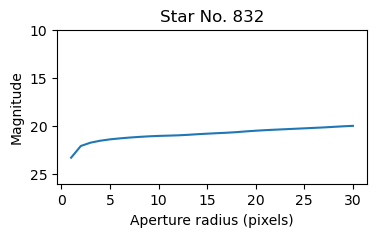

Keep? 


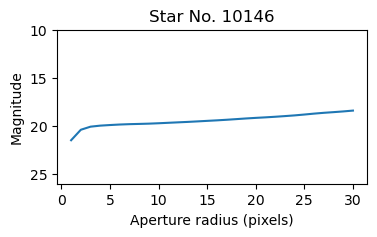

Keep? 


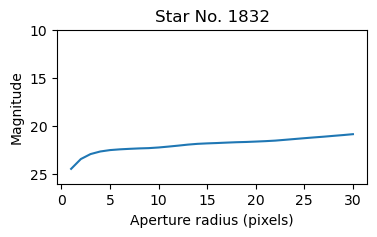

Keep? 


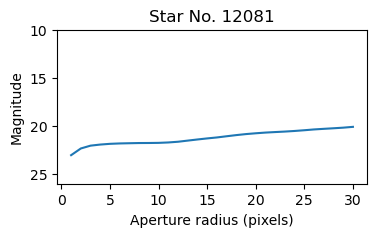

Keep? 


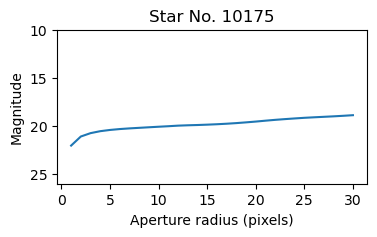

Keep? 


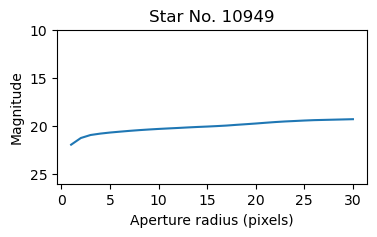

Keep? 


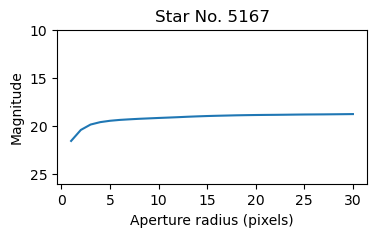

Keep? 


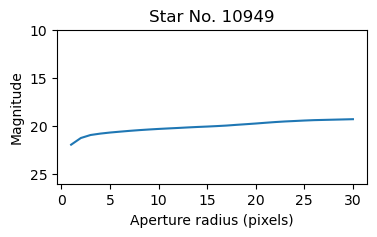

Keep? 


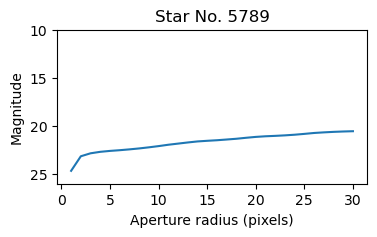

Keep? 


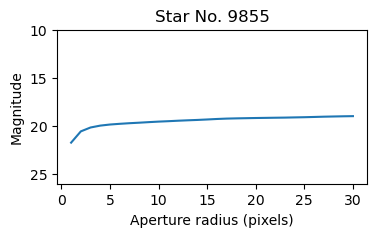

Keep? 


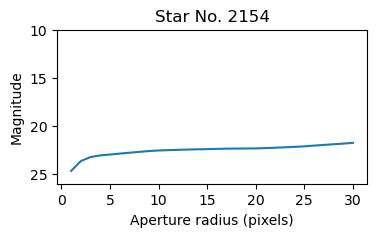

Keep? 


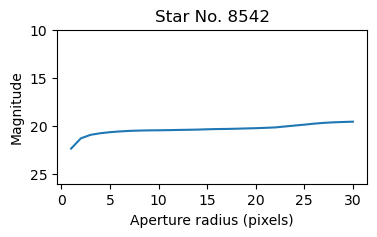

Keep? 


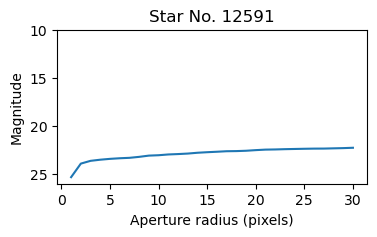

Keep? 


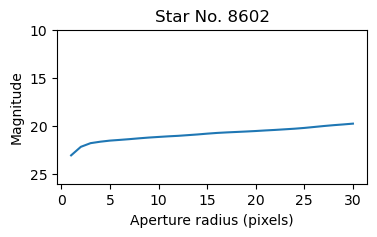

Keep? 


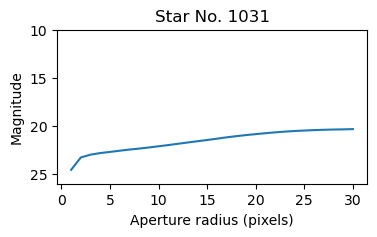

Keep? 


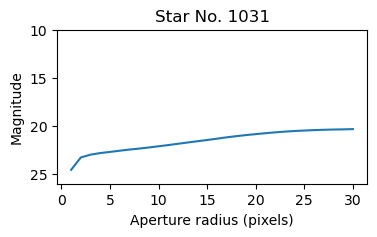

Keep? 


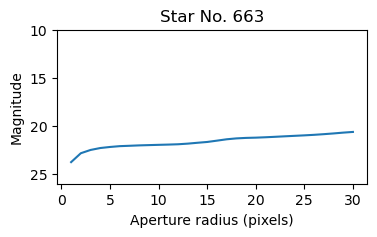

Keep? 


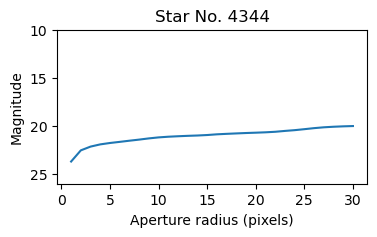

Keep? 


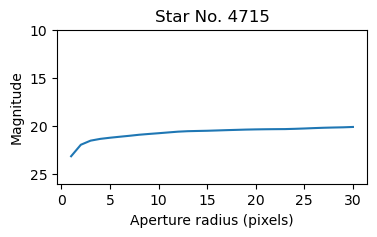

Keep? 


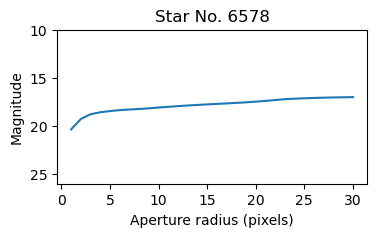

Keep? 


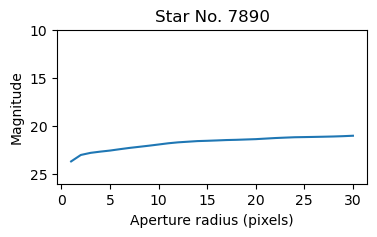

Keep? 


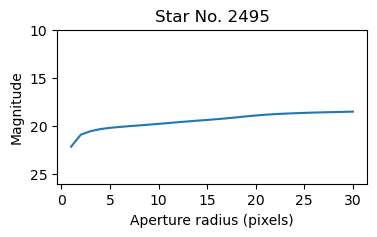

Keep? 


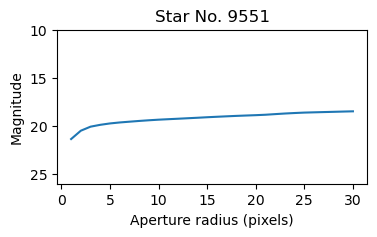

Keep? 


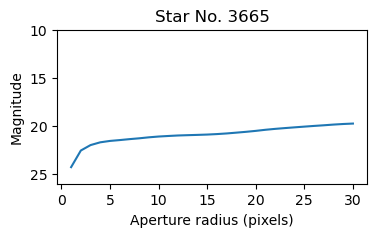

Keep? 


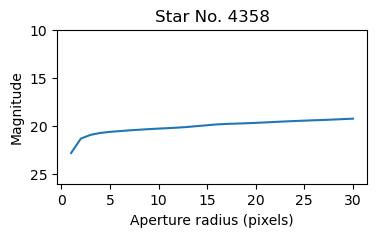

Keep? 


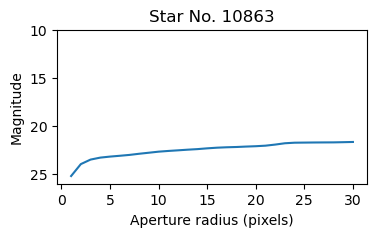

Keep? 


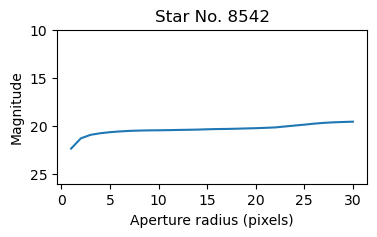

Keep? 


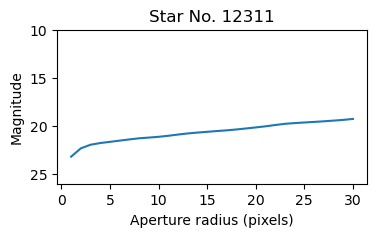

Keep? 


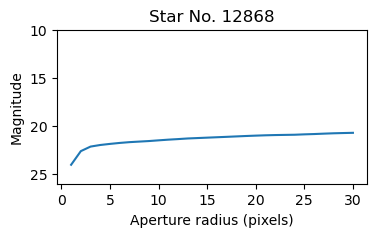

Keep? 


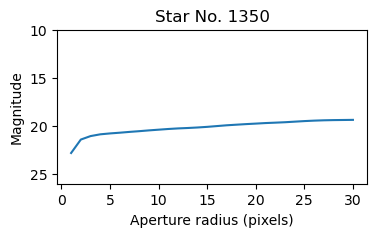

Keep? 


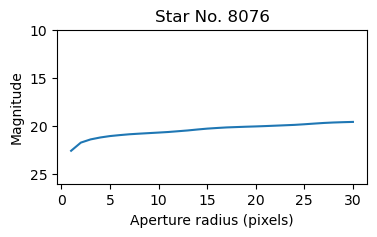

Keep? 


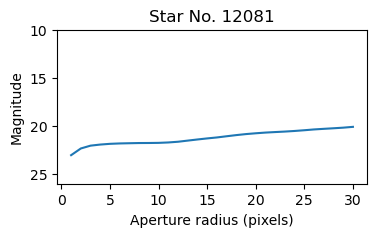

Keep? 


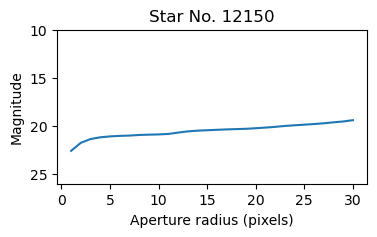

Keep? 


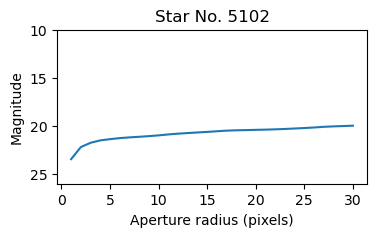

Keep? 


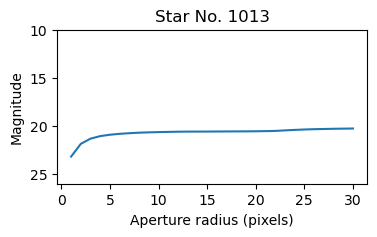

Keep? 


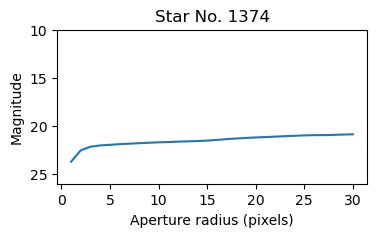

Keep? 


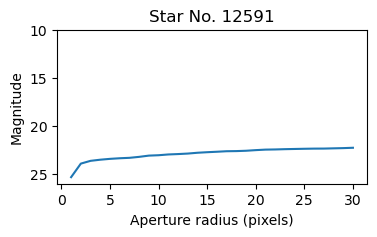

Keep? 


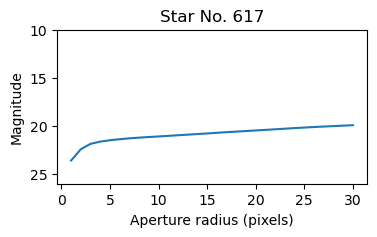

Keep? 


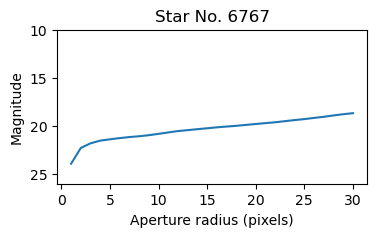

Keep? 


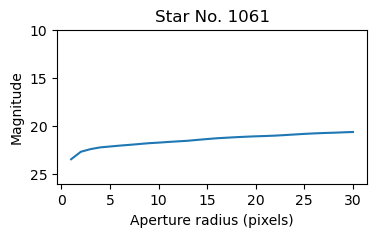

Keep? 


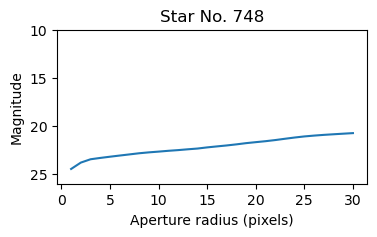

Keep? 


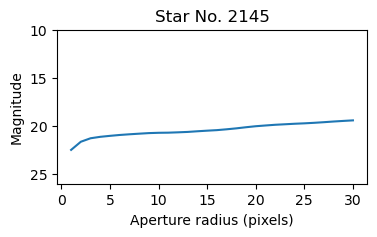

Keep? 


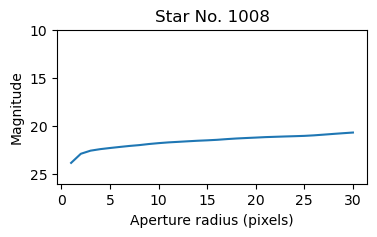

Keep? 


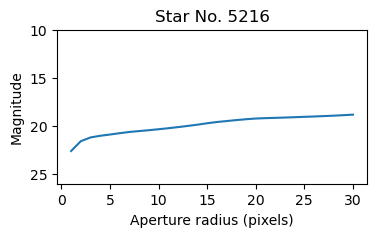

Keep? 


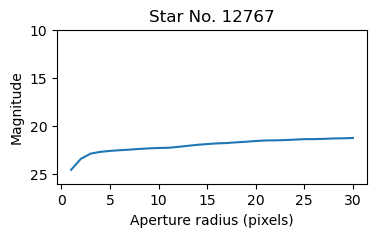

Keep? 


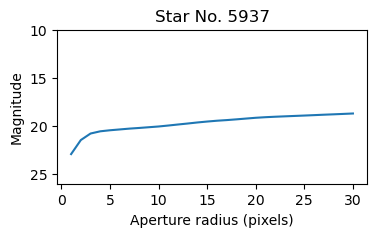

Keep? 


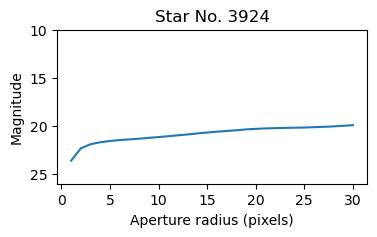

Keep? 


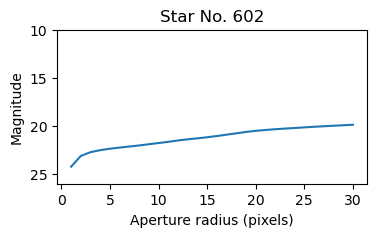

Keep? 


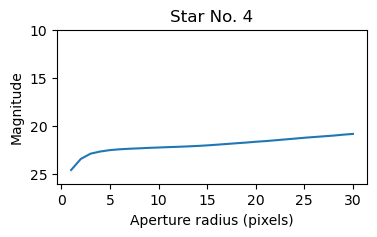

Keep? 


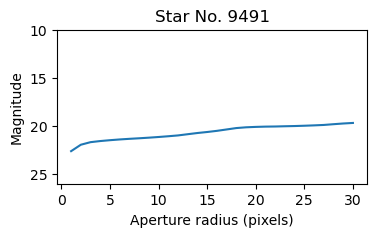

Keep? 


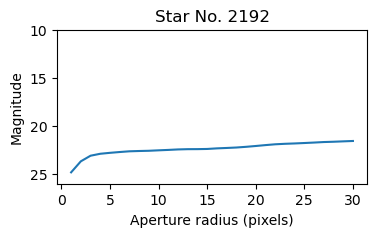

Keep? 


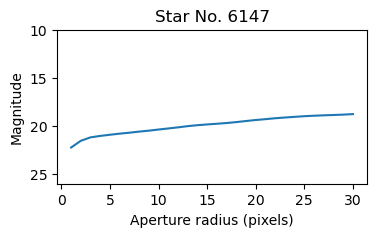

Keep? 


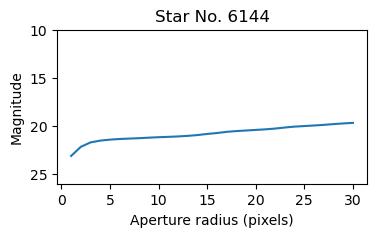

Keep? 


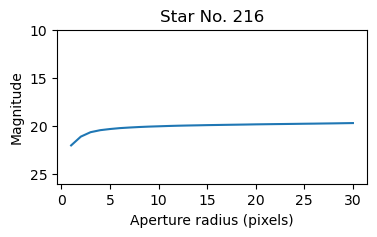

Keep? Y


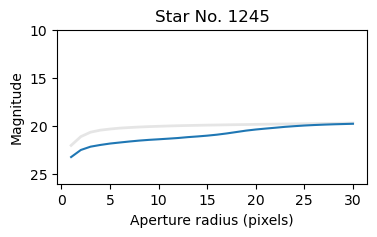

[216]


Keep? 


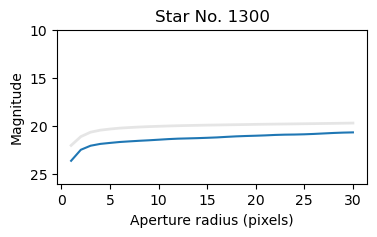

[216]


Keep? 


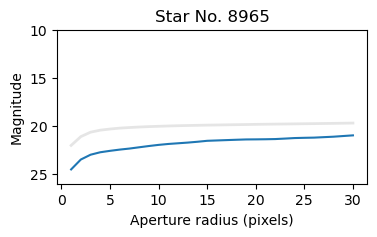

[216]


Keep? 


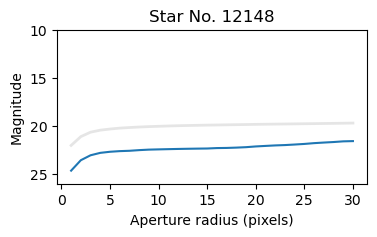

[216]


Keep? 


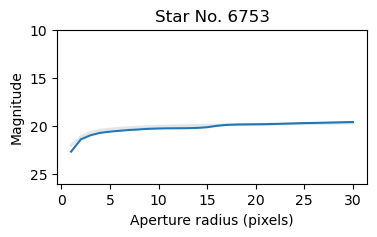

[216]


Keep? 


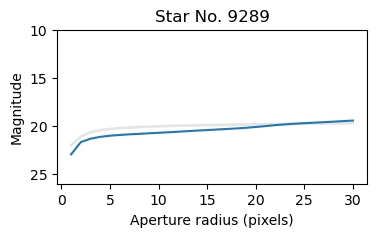

[216]


Keep? 


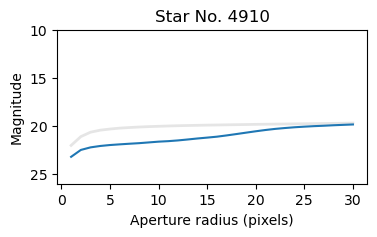

[216]


Keep? 


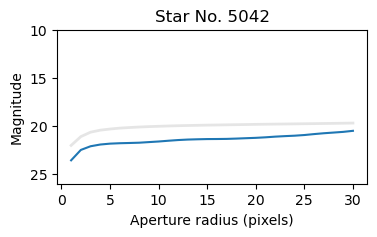

[216]


Keep? 


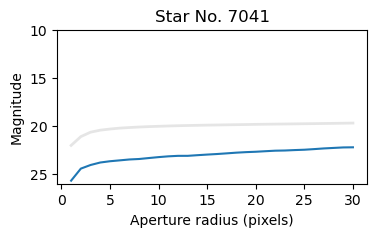

[216]


Keep? 


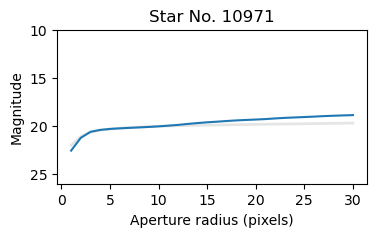

[216]


Keep? 


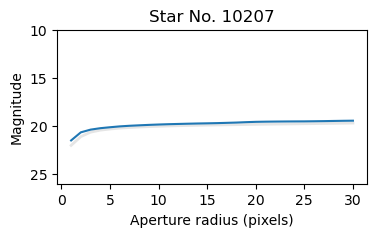

[216]


Keep? Y


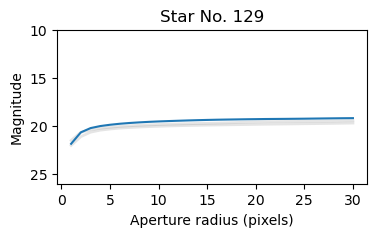

[216, 10207]


Keep? Y


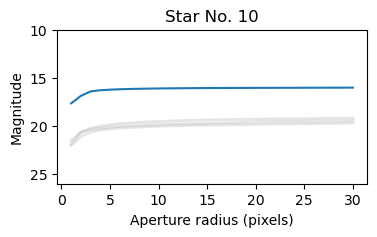

[216, 10207, 129]


Keep? Y


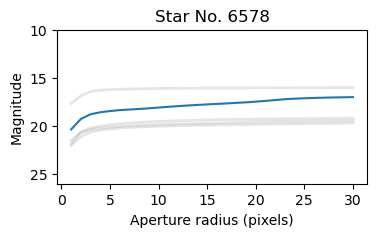

[216, 10207, 129, 10]


Keep? 


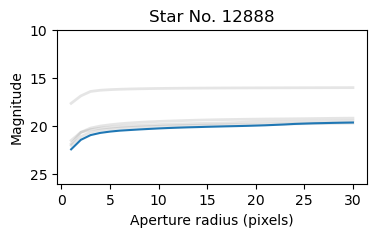

[216, 10207, 129, 10]


Keep? Y


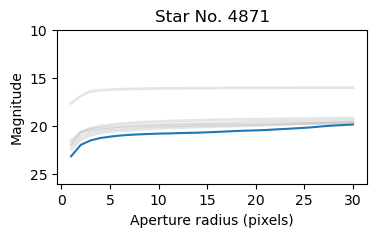

[216, 10207, 129, 10, 12888]


Keep? 


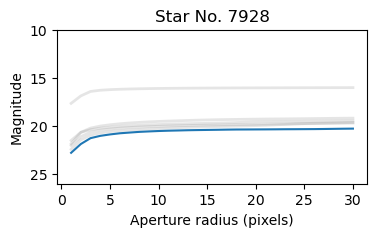

[216, 10207, 129, 10, 12888]


Keep? Y


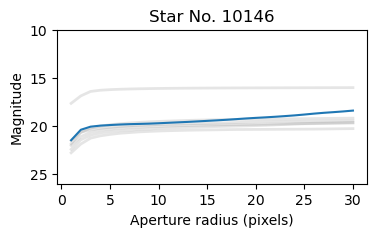

[216, 10207, 129, 10, 12888, 7928]


Keep? 


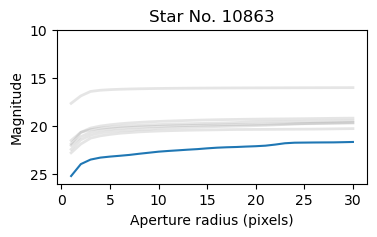

[216, 10207, 129, 10, 12888, 7928]


Keep? 


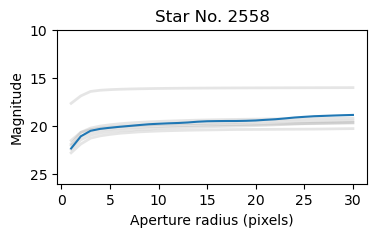

[216, 10207, 129, 10, 12888, 7928]


Keep? 


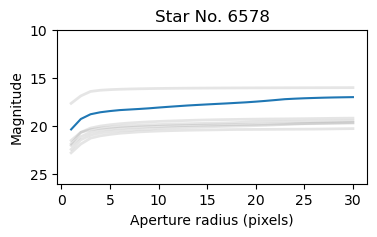

[216, 10207, 129, 10, 12888, 7928]


Keep? 


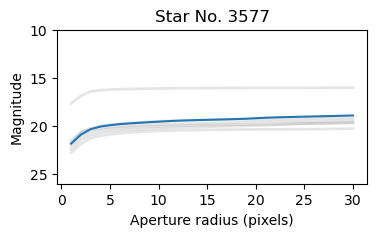

[216, 10207, 129, 10, 12888, 7928]


Keep? Y


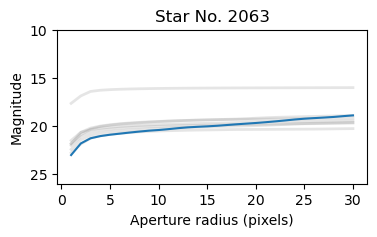

[216, 10207, 129, 10, 12888, 7928, 3577]


Keep? 


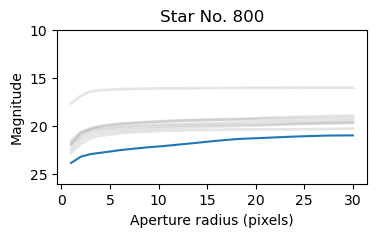

[216, 10207, 129, 10, 12888, 7928, 3577]


Keep? 


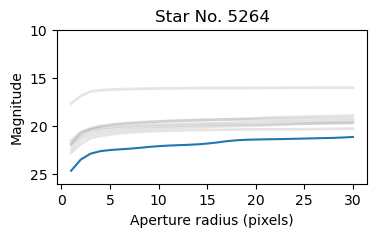

[216, 10207, 129, 10, 12888, 7928, 3577]


Keep? 


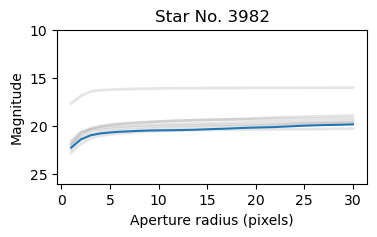

[216, 10207, 129, 10, 12888, 7928, 3577]


Keep? Y


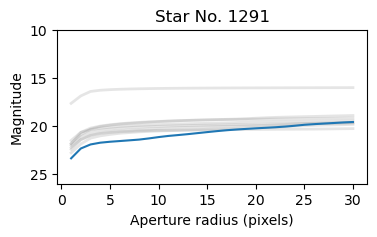

[216, 10207, 129, 10, 12888, 7928, 3577, 3982]


Keep? 


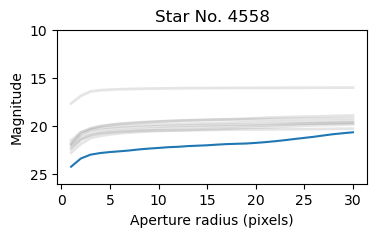

[216, 10207, 129, 10, 12888, 7928, 3577, 3982]


Keep? 


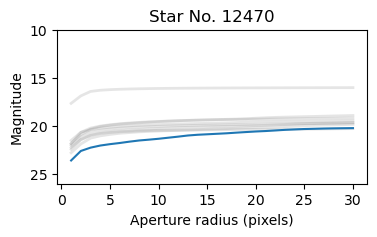

[216, 10207, 129, 10, 12888, 7928, 3577, 3982]


Keep? 


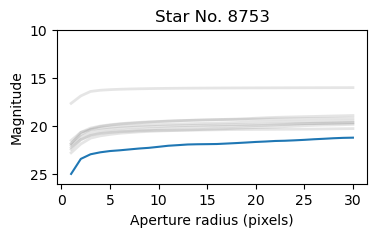

[216, 10207, 129, 10, 12888, 7928, 3577, 3982]


Keep? 


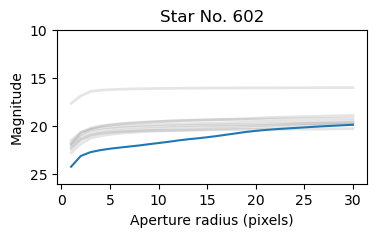

[216, 10207, 129, 10, 12888, 7928, 3577, 3982]


Keep? 


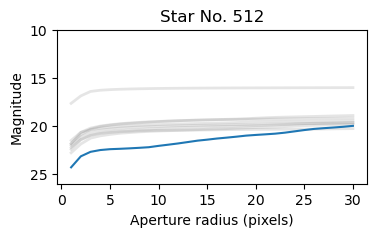

[216, 10207, 129, 10, 12888, 7928, 3577, 3982]


Keep? 


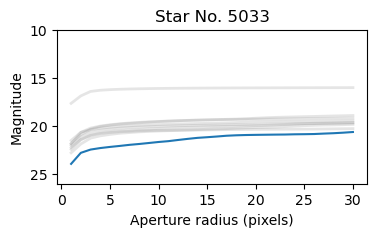

[216, 10207, 129, 10, 12888, 7928, 3577, 3982]


Keep? 


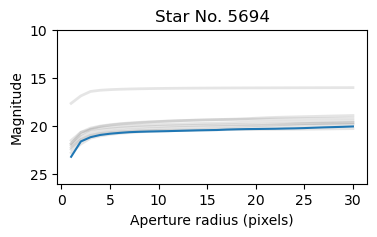

[216, 10207, 129, 10, 12888, 7928, 3577, 3982]


Keep? Y


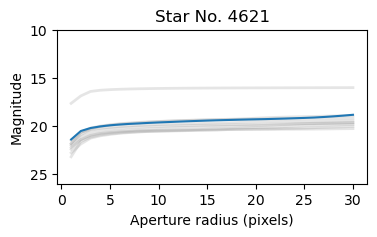

[216, 10207, 129, 10, 12888, 7928, 3577, 3982, 5694]


Keep? 


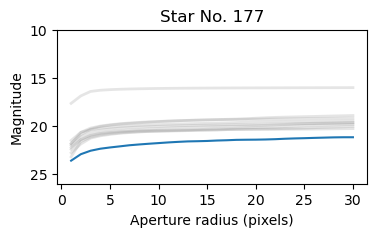

[216, 10207, 129, 10, 12888, 7928, 3577, 3982, 5694]


Keep? 


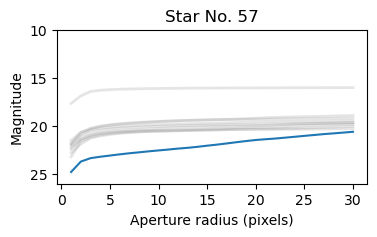

[216, 10207, 129, 10, 12888, 7928, 3577, 3982, 5694]


Keep? 


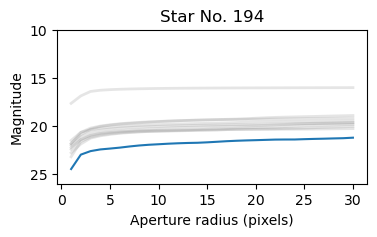

[216, 10207, 129, 10, 12888, 7928, 3577, 3982, 5694]


Keep? 


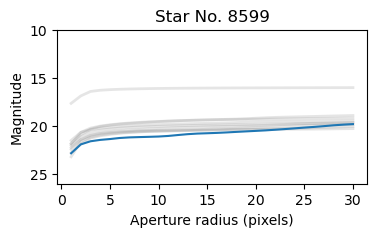

[216, 10207, 129, 10, 12888, 7928, 3577, 3982, 5694]


Keep? 


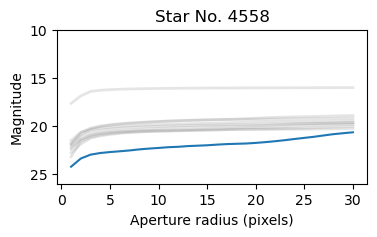

[216, 10207, 129, 10, 12888, 7928, 3577, 3982, 5694]


Keep? 


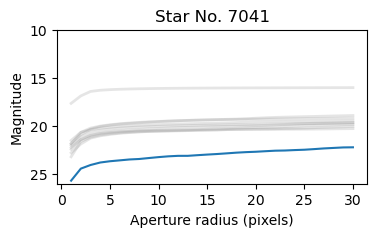

[216, 10207, 129, 10, 12888, 7928, 3577, 3982, 5694]


Keep? 


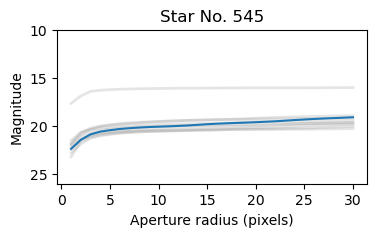

[216, 10207, 129, 10, 12888, 7928, 3577, 3982, 5694]


Keep? 


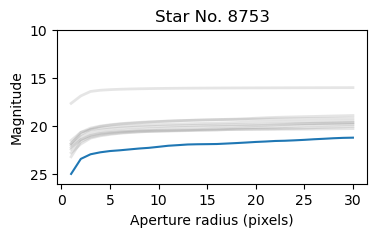

[216, 10207, 129, 10, 12888, 7928, 3577, 3982, 5694]


Keep? 


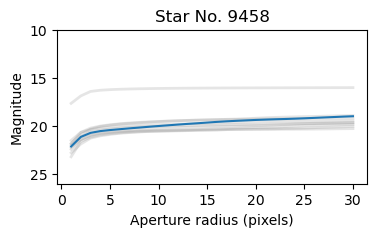

[216, 10207, 129, 10, 12888, 7928, 3577, 3982, 5694]


Keep? 


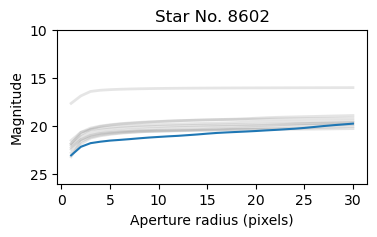

[216, 10207, 129, 10, 12888, 7928, 3577, 3982, 5694]


Keep? 


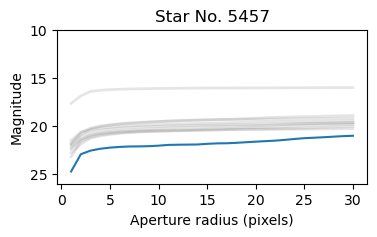

[216, 10207, 129, 10, 12888, 7928, 3577, 3982, 5694]


Keep? 


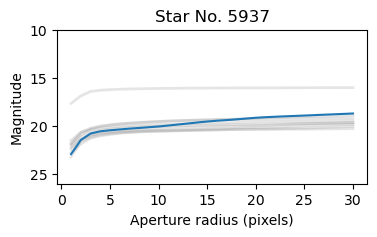

[216, 10207, 129, 10, 12888, 7928, 3577, 3982, 5694]


Keep? 


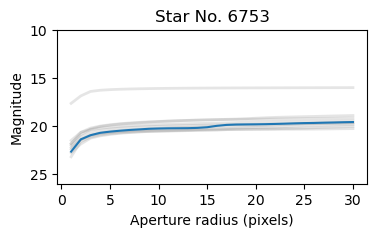

[216, 10207, 129, 10, 12888, 7928, 3577, 3982, 5694]


Keep? 


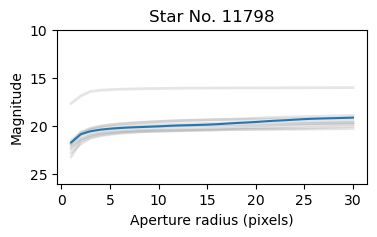

[216, 10207, 129, 10, 12888, 7928, 3577, 3982, 5694]


Keep? 


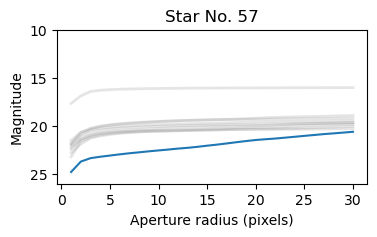

[216, 10207, 129, 10, 12888, 7928, 3577, 3982, 5694]


Keep? 


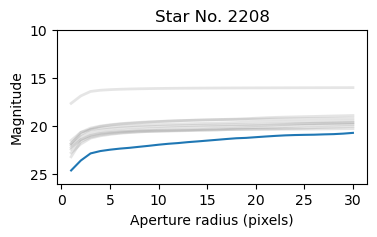

[216, 10207, 129, 10, 12888, 7928, 3577, 3982, 5694]


Keep? 


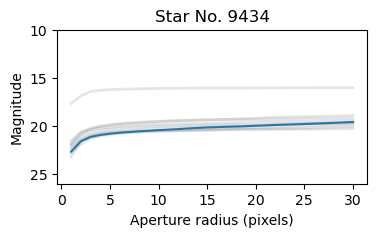

[216, 10207, 129, 10, 12888, 7928, 3577, 3982, 5694]


Keep? 


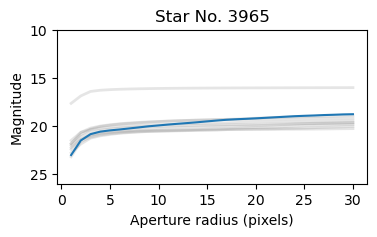

[216, 10207, 129, 10, 12888, 7928, 3577, 3982, 5694]


Keep? 


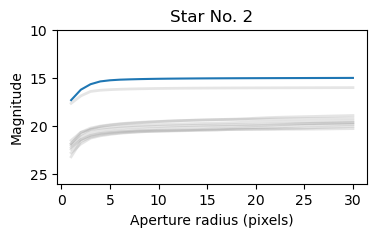

[216, 10207, 129, 10, 12888, 7928, 3577, 3982, 5694]


Keep? Y


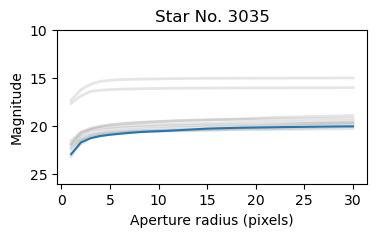

[216, 10207, 129, 10, 12888, 7928, 3577, 3982, 5694, 2]


Keep? Y


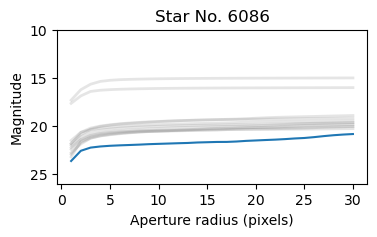

[216, 10207, 129, 10, 12888, 7928, 3577, 3982, 5694, 2, 3035]


Keep? 


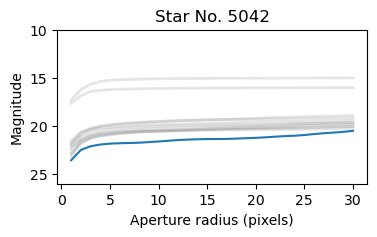

[216, 10207, 129, 10, 12888, 7928, 3577, 3982, 5694, 2, 3035]


Keep? 


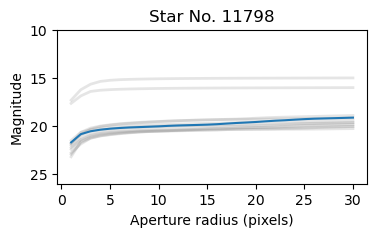

[216, 10207, 129, 10, 12888, 7928, 3577, 3982, 5694, 2, 3035]


Keep? 


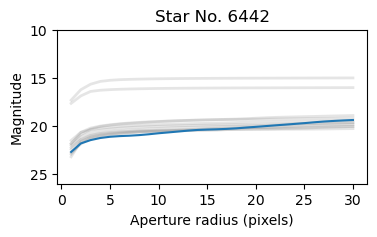

[216, 10207, 129, 10, 12888, 7928, 3577, 3982, 5694, 2, 3035]


Keep? 


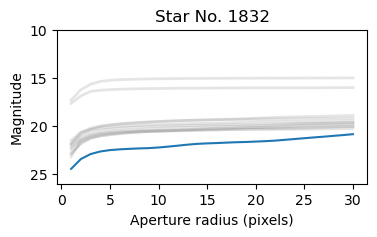

[216, 10207, 129, 10, 12888, 7928, 3577, 3982, 5694, 2, 3035]


Keep? 


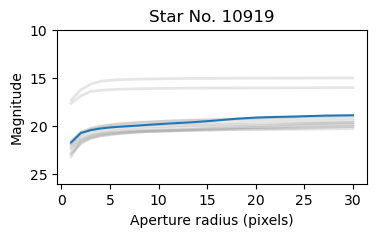

[216, 10207, 129, 10, 12888, 7928, 3577, 3982, 5694, 2, 3035]


Keep? 


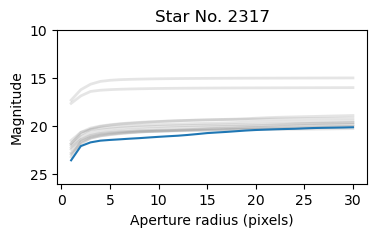

[216, 10207, 129, 10, 12888, 7928, 3577, 3982, 5694, 2, 3035]


Keep? 


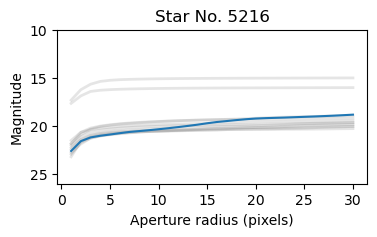

[216, 10207, 129, 10, 12888, 7928, 3577, 3982, 5694, 2, 3035]


Keep? 


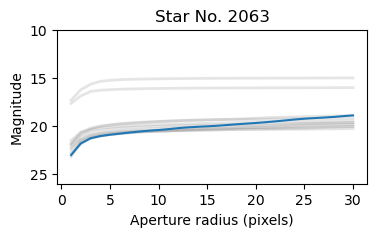

[216, 10207, 129, 10, 12888, 7928, 3577, 3982, 5694, 2, 3035]


Keep? 


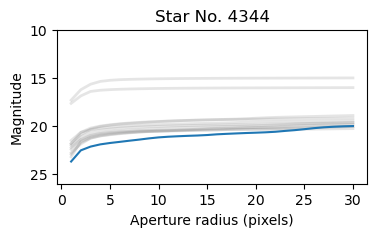

[216, 10207, 129, 10, 12888, 7928, 3577, 3982, 5694, 2, 3035]


Keep? 


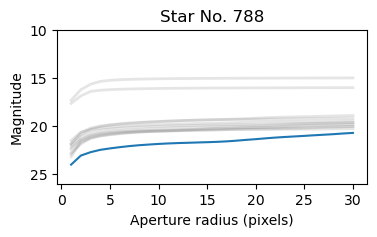

[216, 10207, 129, 10, 12888, 7928, 3577, 3982, 5694, 2, 3035]


Keep? 


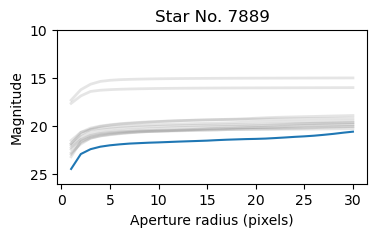

[216, 10207, 129, 10, 12888, 7928, 3577, 3982, 5694, 2, 3035]


Keep? 


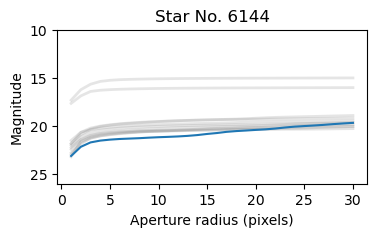

[216, 10207, 129, 10, 12888, 7928, 3577, 3982, 5694, 2, 3035]


Keep? 


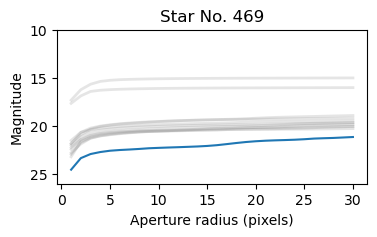

[216, 10207, 129, 10, 12888, 7928, 3577, 3982, 5694, 2, 3035]


Keep? 


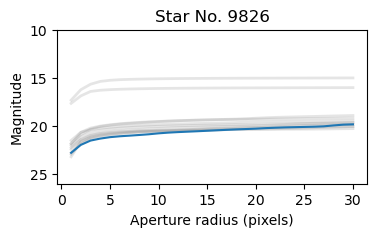

[216, 10207, 129, 10, 12888, 7928, 3577, 3982, 5694, 2, 3035]


Keep? 


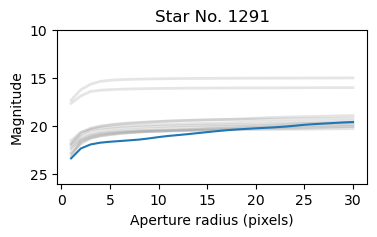

[216, 10207, 129, 10, 12888, 7928, 3577, 3982, 5694, 2, 3035]


Keep? 


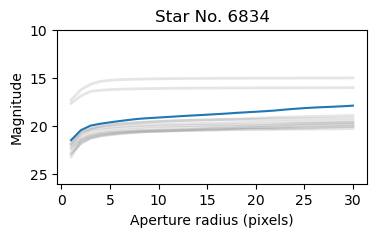

[216, 10207, 129, 10, 12888, 7928, 3577, 3982, 5694, 2, 3035]


Keep? 


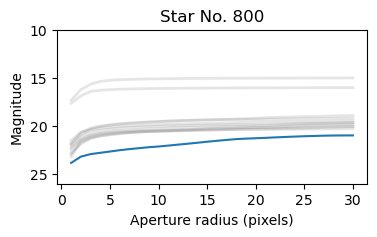

[216, 10207, 129, 10, 12888, 7928, 3577, 3982, 5694, 2, 3035]


Keep? 


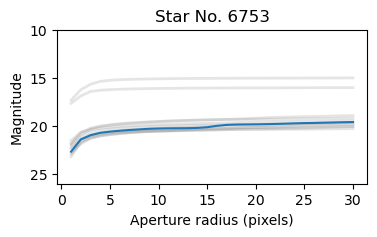

[216, 10207, 129, 10, 12888, 7928, 3577, 3982, 5694, 2, 3035]


Keep? 


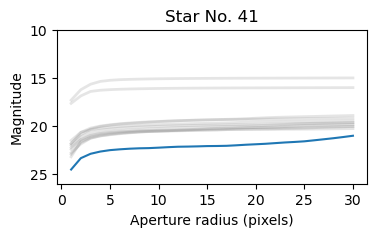

[216, 10207, 129, 10, 12888, 7928, 3577, 3982, 5694, 2, 3035]


Keep? 


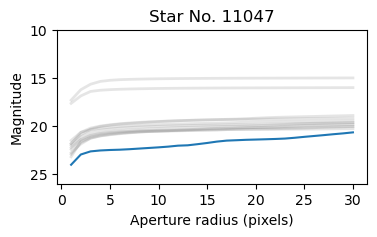

[216, 10207, 129, 10, 12888, 7928, 3577, 3982, 5694, 2, 3035]


Keep? 


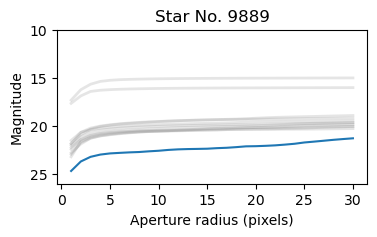

[216, 10207, 129, 10, 12888, 7928, 3577, 3982, 5694, 2, 3035]


Keep? 


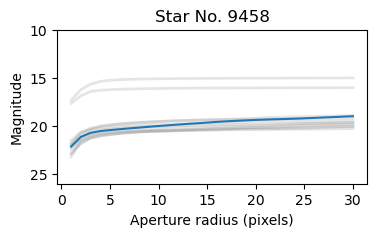

[216, 10207, 129, 10, 12888, 7928, 3577, 3982, 5694, 2, 3035]


Keep? 


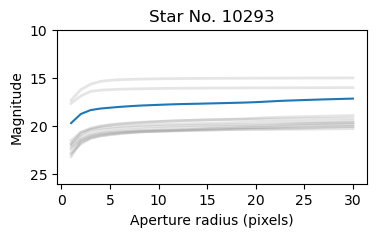

[216, 10207, 129, 10, 12888, 7928, 3577, 3982, 5694, 2, 3035]


Keep? Y


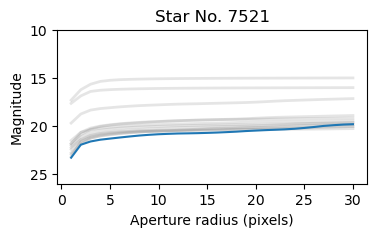

[216, 10207, 129, 10, 12888, 7928, 3577, 3982, 5694, 2, 3035, 10293]


Keep? 


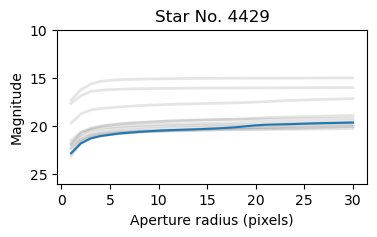

[216, 10207, 129, 10, 12888, 7928, 3577, 3982, 5694, 2, 3035, 10293]


Keep? 


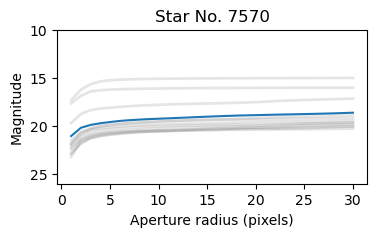

[216, 10207, 129, 10, 12888, 7928, 3577, 3982, 5694, 2, 3035, 10293]


Keep? Y


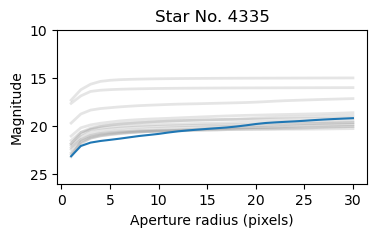

[216, 10207, 129, 10, 12888, 7928, 3577, 3982, 5694, 2, 3035, 10293, 7570]


Keep? 


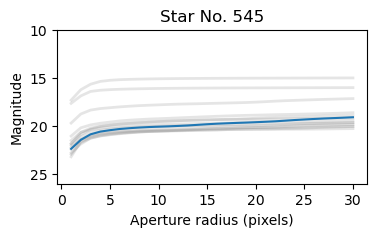

[216, 10207, 129, 10, 12888, 7928, 3577, 3982, 5694, 2, 3035, 10293, 7570]


Keep? 


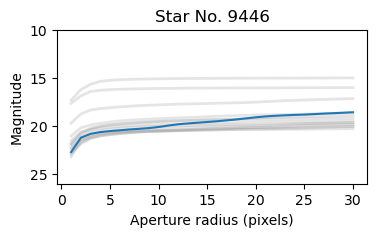

[216, 10207, 129, 10, 12888, 7928, 3577, 3982, 5694, 2, 3035, 10293, 7570]


Keep? 


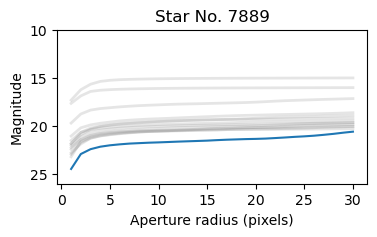

[216, 10207, 129, 10, 12888, 7928, 3577, 3982, 5694, 2, 3035, 10293, 7570]


Keep? 


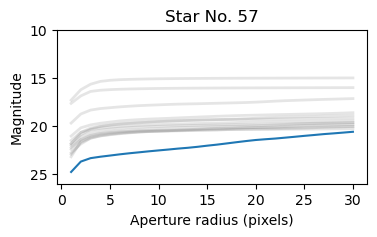

[216, 10207, 129, 10, 12888, 7928, 3577, 3982, 5694, 2, 3035, 10293, 7570]


Keep? 


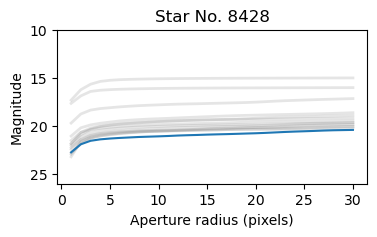

[216, 10207, 129, 10, 12888, 7928, 3577, 3982, 5694, 2, 3035, 10293, 7570]


Keep? Y


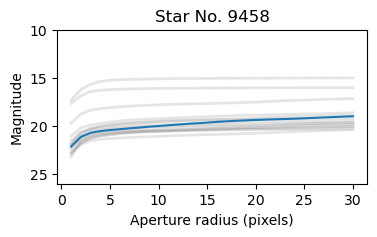

[216, 10207, 129, 10, 12888, 7928, 3577, 3982, 5694, 2, 3035, 10293, 7570, 8428]


Keep? 


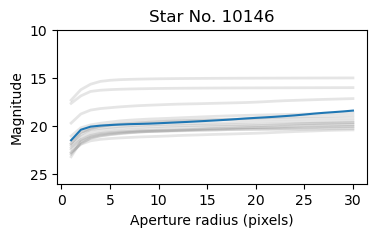

[216, 10207, 129, 10, 12888, 7928, 3577, 3982, 5694, 2, 3035, 10293, 7570, 8428]


Keep? 


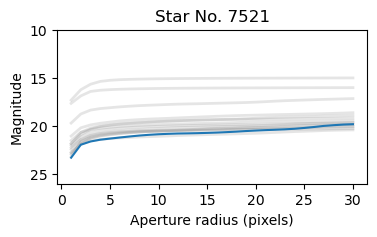

[216, 10207, 129, 10, 12888, 7928, 3577, 3982, 5694, 2, 3035, 10293, 7570, 8428]


Keep? 


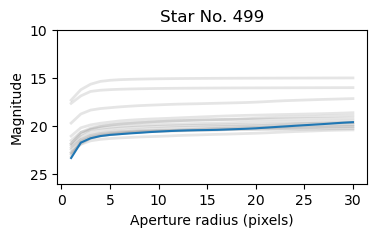

[216, 10207, 129, 10, 12888, 7928, 3577, 3982, 5694, 2, 3035, 10293, 7570, 8428]


Keep? 


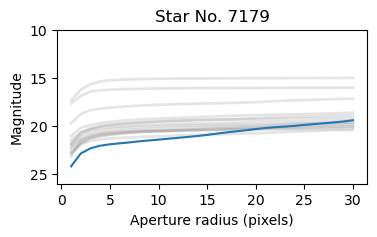

[216, 10207, 129, 10, 12888, 7928, 3577, 3982, 5694, 2, 3035, 10293, 7570, 8428]


Keep? 


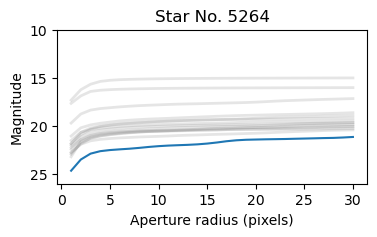

[216, 10207, 129, 10, 12888, 7928, 3577, 3982, 5694, 2, 3035, 10293, 7570, 8428]


Keep? 


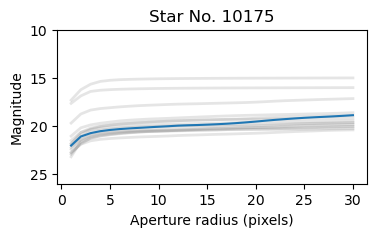

[216, 10207, 129, 10, 12888, 7928, 3577, 3982, 5694, 2, 3035, 10293, 7570, 8428]


Keep? 


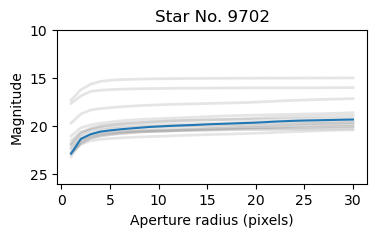

[216, 10207, 129, 10, 12888, 7928, 3577, 3982, 5694, 2, 3035, 10293, 7570, 8428]


Keep? Y


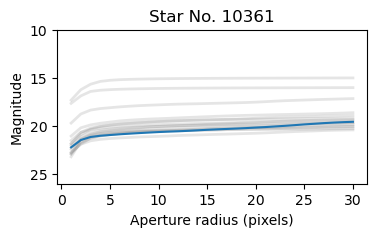

[216, 10207, 129, 10, 12888, 7928, 3577, 3982, 5694, 2, 3035, 10293, 7570, 8428, 9702]


Keep? 


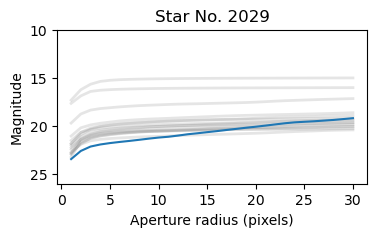

[216, 10207, 129, 10, 12888, 7928, 3577, 3982, 5694, 2, 3035, 10293, 7570, 8428, 9702]


Keep? 


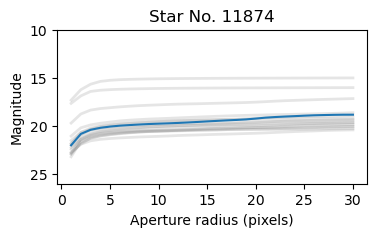

[216, 10207, 129, 10, 12888, 7928, 3577, 3982, 5694, 2, 3035, 10293, 7570, 8428, 9702]


Keep? 


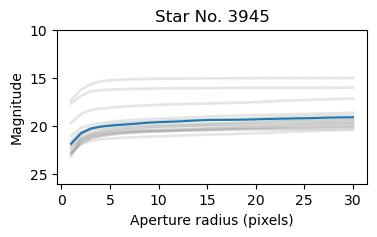

[216, 10207, 129, 10, 12888, 7928, 3577, 3982, 5694, 2, 3035, 10293, 7570, 8428, 9702]


Keep? Y


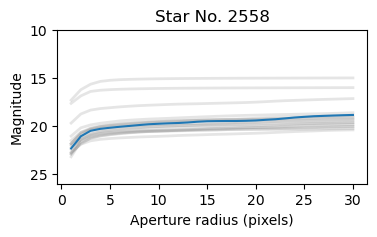

[216, 10207, 129, 10, 12888, 7928, 3577, 3982, 5694, 2, 3035, 10293, 7570, 8428, 9702, 3945]


Keep? 


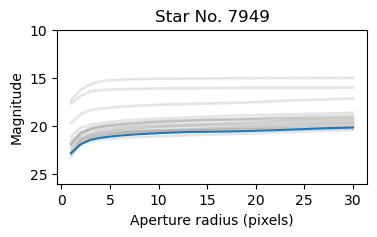

[216, 10207, 129, 10, 12888, 7928, 3577, 3982, 5694, 2, 3035, 10293, 7570, 8428, 9702, 3945]


Keep? Y


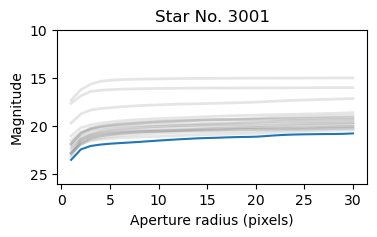

[216, 10207, 129, 10, 12888, 7928, 3577, 3982, 5694, 2, 3035, 10293, 7570, 8428, 9702, 3945, 7949]


Keep? 


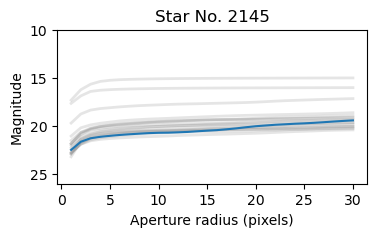

[216, 10207, 129, 10, 12888, 7928, 3577, 3982, 5694, 2, 3035, 10293, 7570, 8428, 9702, 3945, 7949]


Keep? 


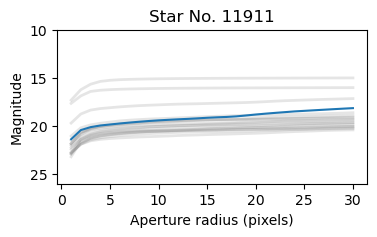

[216, 10207, 129, 10, 12888, 7928, 3577, 3982, 5694, 2, 3035, 10293, 7570, 8428, 9702, 3945, 7949]


Keep? 


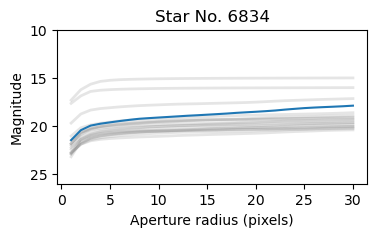

[216, 10207, 129, 10, 12888, 7928, 3577, 3982, 5694, 2, 3035, 10293, 7570, 8428, 9702, 3945, 7949]


Keep? 


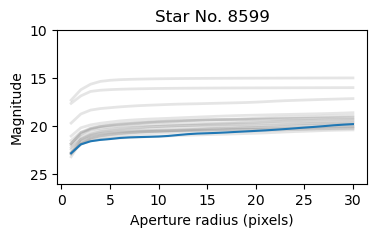

[216, 10207, 129, 10, 12888, 7928, 3577, 3982, 5694, 2, 3035, 10293, 7570, 8428, 9702, 3945, 7949]


Keep? 


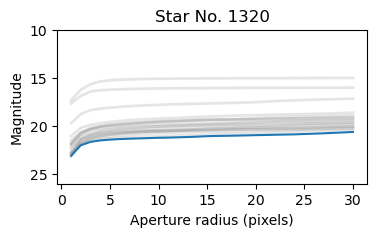

[216, 10207, 129, 10, 12888, 7928, 3577, 3982, 5694, 2, 3035, 10293, 7570, 8428, 9702, 3945, 7949]


Keep? Y


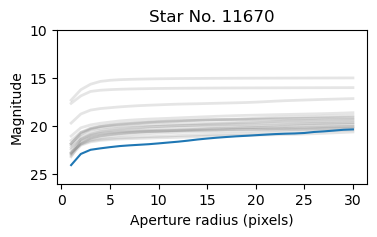

[216, 10207, 129, 10, 12888, 7928, 3577, 3982, 5694, 2, 3035, 10293, 7570, 8428, 9702, 3945, 7949, 1320]


Keep? 


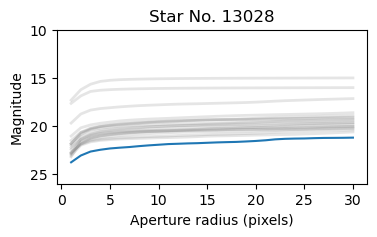

[216, 10207, 129, 10, 12888, 7928, 3577, 3982, 5694, 2, 3035, 10293, 7570, 8428, 9702, 3945, 7949, 1320]


Keep? 


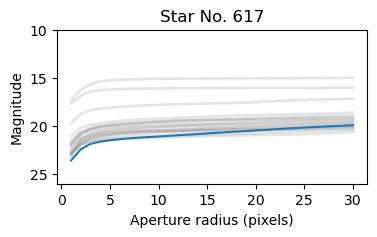

[216, 10207, 129, 10, 12888, 7928, 3577, 3982, 5694, 2, 3035, 10293, 7570, 8428, 9702, 3945, 7949, 1320]


Keep? 


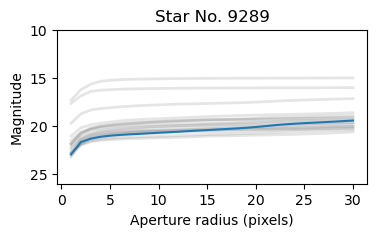

[216, 10207, 129, 10, 12888, 7928, 3577, 3982, 5694, 2, 3035, 10293, 7570, 8428, 9702, 3945, 7949, 1320]


Keep? 


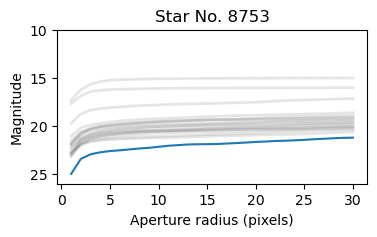

[216, 10207, 129, 10, 12888, 7928, 3577, 3982, 5694, 2, 3035, 10293, 7570, 8428, 9702, 3945, 7949, 1320]


Keep? 


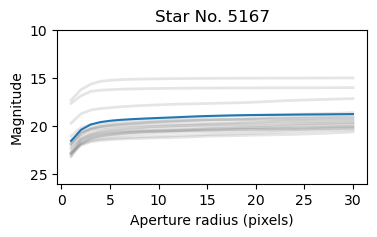

[216, 10207, 129, 10, 12888, 7928, 3577, 3982, 5694, 2, 3035, 10293, 7570, 8428, 9702, 3945, 7949, 1320]


Keep? Y


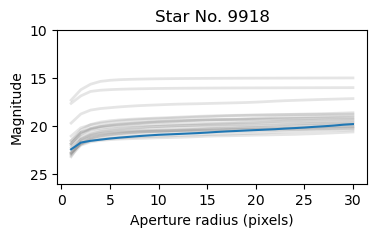

[216, 10207, 129, 10, 12888, 7928, 3577, 3982, 5694, 2, 3035, 10293, 7570, 8428, 9702, 3945, 7949, 1320, 5167]


Keep? 


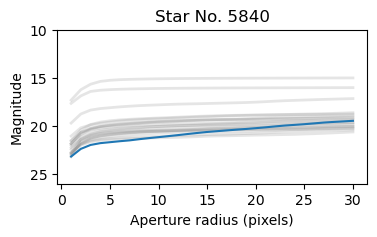

[216, 10207, 129, 10, 12888, 7928, 3577, 3982, 5694, 2, 3035, 10293, 7570, 8428, 9702, 3945, 7949, 1320, 5167]


Keep? 


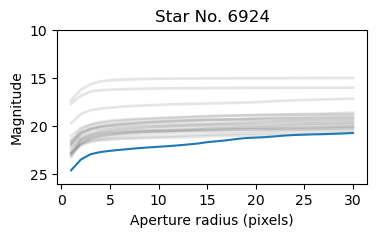

[216, 10207, 129, 10, 12888, 7928, 3577, 3982, 5694, 2, 3035, 10293, 7570, 8428, 9702, 3945, 7949, 1320, 5167]


Keep? 


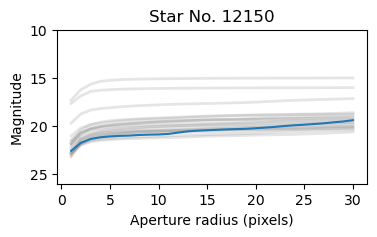

[216, 10207, 129, 10, 12888, 7928, 3577, 3982, 5694, 2, 3035, 10293, 7570, 8428, 9702, 3945, 7949, 1320, 5167]


Keep? 


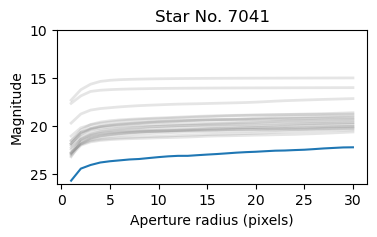

[216, 10207, 129, 10, 12888, 7928, 3577, 3982, 5694, 2, 3035, 10293, 7570, 8428, 9702, 3945, 7949, 1320, 5167]


Keep? 


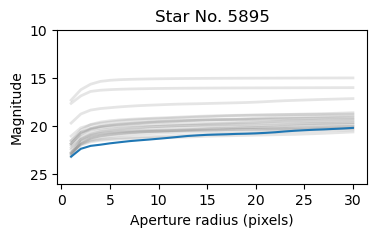

[216, 10207, 129, 10, 12888, 7928, 3577, 3982, 5694, 2, 3035, 10293, 7570, 8428, 9702, 3945, 7949, 1320, 5167]


Keep? 


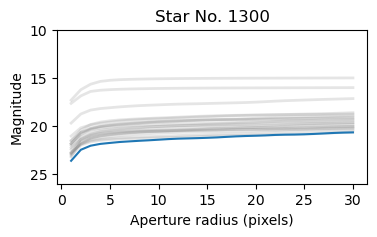

[216, 10207, 129, 10, 12888, 7928, 3577, 3982, 5694, 2, 3035, 10293, 7570, 8428, 9702, 3945, 7949, 1320, 5167]


Keep? Y


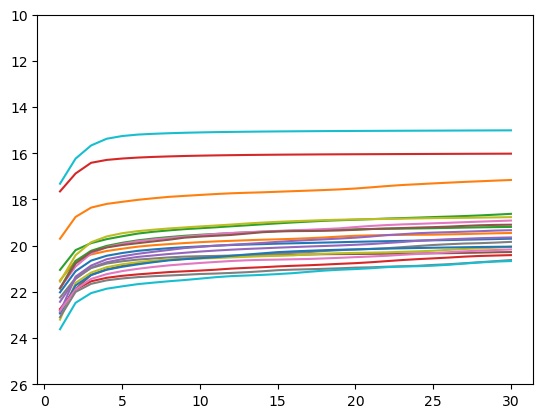

Check all profiles and enter 'y' to continue calculation:  y


Calculating magnitudes...
photometry_M66_f814w_wfc3_sources.ecsv saved
photometry_M66_f814w_wfc3_extended.ecsv saved
DONE!
CPU times: user 29.9 s, sys: 4.61 s, total: 34.5 s
Wall time: 18min 5s


(np.float64(-0.9751453546249613),
 np.float64(0.185828626320169),
 np.float64(-0.34269964472063164),
 np.float64(0.09407035935085337))

In [9]:
%%time

# do it on green filter, base filter 
# reduce nuM_stars for the ultraviolet 275, 336
hdu = fits.open("M66_mosaic_acs_f555w_drc_sci.fits")
# fwhm, sigma (signal to noise, make it smaller 2.5 or 2)
RunPhots(hdu, gal="M66", instrument="WFC3", filter="F555W",
        fwhm_arcs=0.3, num_stars=20)

In [ ]:
CorrectAp

# Manual Source Identification and Photometry

In [24]:
fwhm = 0.3     # in arcseconds
pixtoarcs = 0.05
data = fits.getdata('M66_mosaic_acs_f814w_drc_sci.fits')

mean, median, std = sigma_clipped_stats(data, sigma=5) # what is sigma here? 
                                        
daofind = DAOStarFinder(fwhm=fwhm/pixtoarcs, threshold=5*std)
objects = daofind(data)

## Extracting Photometry

In [29]:
positions = np.transpose((objects['xcentroid'], objects['ycentroid']))

ap_rads = [i for i in range(1,31)]
aperture_full = [CircularAperture(positions, r=r) for r in ap_rads]

In [30]:
sigma_clip = SigmaClip(sigma=5)
bkg_estimator = MedianBackground()
bkg = Background2D(data, (50, 50), filter_size=(3, 3),
                  sigma_clip=sigma_clip,
                  bkg_estimator=bkg_estimator)
data_sub = data - bkg.background

In [32]:
phot_full = aperture_photometry(data_sub, aperture_full, method="center")

hdu = fits.open('M66_mosaic_acs_f555w_drc_sci.fits')
phot_full = aperture_photometry(data_sub, aperture_full, 
    		            error=calc_total_error(data, data-data_sub,
    				  effective_gain=hdu[0].header["EXPTIME"]))

phot_full.write("M66_photometry.ecsv")